In [1]:
import os
import re
import PyPDF2
import json

# import nltk
# nltk.download('punkt')

from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm

# Load environment variables from the .envrc file
load_dotenv('../.envrc')

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

In [2]:
from elasticsearch import Elasticsearch

# Create an Elasticsearch client instance
es = Elasticsearch(
    [{'scheme': 'http', 'host': 'localhost', 'port': 9200}]
)

index_name = 'enhanced_stock_analyzer'

In [3]:
index_mapping = {
    'mappings': {
        'properties': {
            'source': {'type': 'keyword'},
            'chunk_id': {'type': 'keyword'},
            'content': {'type': 'text'},
            'summary': {'type': 'text'},
            'key_topics': {'type': 'text'},
            'embedding': {
                'type': 'dense_vector',
                'dims': 384  # Adjust based on your embedding dimensions
            }
        }
    }
}

# Create or update the index
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=index_mapping)
else:
    es.indices.put_mapping(index=index_name, body=index_mapping)


In [4]:
# letters_path = '../data/buffet_letters.json'
# with open(letters_path, 'r') as json_file:
#     processed_letters = json.load(json_file)

# report_path = '../data/annual_reports.json'
# with open(report_path, 'r') as json_file:
#     processed_reports = json.load(json_file)


# for item in processed_letters:
#     metdt = item['metadata'].split('\n')
#     item['summary'] = metdt[0][len("summary:"):].strip()
#     item['key_topics'] = [i.strip() for i in metdt[1][len("key_topics:"):].strip().split(',')]
#     del item['metadata']
    
# for item in processed_reports:
    
#     metdt = item['metadata'].split('\n')

#     item['summary'] = metdt[0][len("summary:"):].strip()
#     item['key_topics'] = [i.strip() for i in metdt[1][len("key_topics:"):].strip().split(',')]
#     del item['metadata']

#     item['source'] = item['ticker'] + " annual " + item['source']
#     del item['ticker']


papers_path = '../data/research_papers.json'
with open(papers_path, 'r') as json_file:
    processed_papers = json.load(json_file)

for item in processed_papers:
    
    metdt = item['metadata'].split('\n')

    item['summary'] = metdt[0][len("summary:"):].strip()
    item['key_topics'] = [i.strip() for i in metdt[1][len("key_topics:"):].strip().split(',')]
    del item['metadata']

all_data = processed_papers #processed_letters #+ processed_reports
len(all_data)

668

In [5]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# def get_embeddings(text, model_name='yiyanghkust/finbert-pretrain'):
#     """
#     Generates embeddings for the given text using a pre-trained model.

#     Parameters:
#     - text (str): The input text for which embeddings are to be generated.
#     - model_name (str): The name of the pre-trained model to use (default is 'yiyanghkust/finbert-pretrain').

#     Returns:
#     - numpy.ndarray: The [CLS] token embedding as a numpy array.
#     """
#     # Load the tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)

#     # Tokenize the input text
#     encoded_input = tokenizer(
#         text,
#         add_special_tokens=True,
#         max_length=384,
#         padding='max_length',
#         truncation=True,
#         return_tensors='pt'
#     )

#     input_ids = encoded_input['input_ids']
#     attention_mask = encoded_input['attention_mask']

#     # Ensure the model is in evaluation mode
#     model.eval()

#     # Move inputs to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)

#     # Generate embeddings
#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#     # Extract the [CLS] token embedding
#     cls_embedding = outputs.last_hidden_state[:, 0, :]  # Shape: (1, hidden_size)

#     # Convert to a NumPy array
#     cls_embedding_np = cls_embedding.cpu().numpy()  # Move to CPU if necessary

#     return cls_embedding_np

# # Example usage
# # text = "The company's revenue increased by 20% in the last quarter."
# # embeddings = get_embeddings(text)
# # print(embeddings)


In [5]:
from elasticsearch.helpers import bulk

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  #('FinLang/finance-embeddings-investopedia') #('all-MiniLM-L6-v2')  #("philschmid/bge-base-financial-matryoshka")

def generate_actions(data):
    for item in data:
        embedding = model.encode(item['content']).tolist()  #get_embeddings(item['content']).tolist() #
        yield {
            '_index': index_name,
            '_id': item['chunk_id'],
            '_source': {
                'source': item['source'],
                'chunk_id': item['chunk_id'],
                'content': item['content'],
                'summary': item.get('summary', ''),
                'key_topics': item.get('key_topics', ''),
                'embedding': embedding
            }
        }

# Bulk index the data
bulk(es, generate_actions(all_data))


/Users/whysocurious/.local/share/virtualenvs/buffett-wisdom-rag-yofaZaKX/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/whysocurious/.local/share/virtualenvs/buffett-wisdom-rag-yofaZaKX/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
indx = bulk(es, generate_actions(all_data))

In [7]:
indx

(668, [])

In [7]:
index_mapping                   

{'mappings': {'properties': {'source': {'type': 'keyword'},
   'chunk_id': {'type': 'keyword'},
   'content': {'type': 'text'},
   'summary': {'type': 'text'},
   'key_topics': {'type': 'text'},
   'embedding': {'type': 'dense_vector', 'dims': 384}}}}

In [8]:

def hybrid_search(query, index=index_name, keyword_top_k=10, final_top_k=10):
    """
    Performs a hybrid search using keyword (multi_match) and semantic (k-NN) search, then re-ranks the results.

    Parameters:
    - query (str): The user's question.
    - index (str): The Elasticsearch index name.
    - keyword_top_k (int): Number of top documents to retrieve from keyword search.
    - final_top_k (int): Number of top documents to return after re-ranking.

    Returns:
    - List of dictionaries containing the re-ranked search results.
    """

    # Step 1: Perform Keyword Search (multi_match)
    keyword_query = {
        'size': keyword_top_k,
        'query': {
            'multi_match': {
                'query': query,
                'fields': ['content','summary^2','key_topics^2'],
                'fuzziness': 'AUTO'
            }
        },
        '_source': ['source', 'chunk_id', 'content', 'embedding', 'summary', 'key_topics']
    }
    keyword_response = es.search(index=index, body=keyword_query)
    keyword_hits = keyword_response['hits']['hits']

    # Step 2: Perform Semantic Search (k-NN)
    # Generate embedding for the query
    query_embedding = model.encode(query).tolist()

    # Build the semantic search query
    # Semantic search using script_score
    semantic_query = {
        'size': keyword_top_k,
        'query': {
            'script_score': {
                'query': {'match_all': {}},
                'script': {
                    'source': "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                    'params': {'query_vector': query_embedding}
                }
            }
        },
        '_source': ['source', 'chunk_id', 'content', 'embedding', 'summary', 'key_topics']
    }

    semantic_response = es.search(index=index, body=semantic_query)
    semantic_hits = semantic_response['hits']['hits']

    # Step 3: Combine Results
    combined_hits = {}
    # Process keyword search results
    for hit in keyword_hits:
        chunk_id = hit['_id']
        combined_hits[chunk_id] = {
            'source': hit['_source']['source'],
            'year': hit['_source'].get('year', ''),
            'chunk_id': chunk_id,
            'content': hit['_source']['content'],
            'summary': hit['_source']['summary'],
            'key_topics': hit['_source']['key_topics'],
            'keyword_score': hit['_score'],
            'semantic_score': 0  # Will be updated if exists in semantic_hits
        }
    # Process semantic search results
    for hit in semantic_hits:
        chunk_id = hit['_id']
        if chunk_id in combined_hits:
            combined_hits[chunk_id]['semantic_score'] = hit['_score']
        else:
            combined_hits[chunk_id] = {
                'source': hit['_source']['source'],
                # 'year': hit['_source'].get('year', ''),
                'chunk_id': chunk_id,
                'content': hit['_source']['content'],
                'summary': hit['_source']['summary'],
                'key_topics': hit['_source']['key_topics'],
                'keyword_score': 0,
                'semantic_score': hit['_score']
            }

    # Step 4: Re-rank the Combined Results
    # Normalize scores
    max_keyword_score = max(hit['keyword_score'] for hit in combined_hits.values()) or 1
    max_semantic_score = max(hit['semantic_score'] for hit in combined_hits.values()) or 1

    for hit in combined_hits.values():
        hit['keyword_score_normalized'] = hit['keyword_score'] / max_keyword_score
        hit['semantic_score_normalized'] = hit['semantic_score'] / max_semantic_score
        # Combine scores with weights (adjust weights as needed)
        hit['combined_score'] = (0.6 * hit['keyword_score_normalized']) + (0.4 * hit['semantic_score_normalized'])

    # Sort the hits based on combined score
    re_ranked_hits = sorted(combined_hits.values(), key=lambda x: x['combined_score'], reverse=True)

    # Step 5: Return Top-K Re-Ranked Documents
    final_results = re_ranked_hits[:final_top_k]
    return final_results


In [9]:
# query = "What is mean reversion strategy ?" #"Explain Warren Buffett's investment strategy focusing on companies with strong moats." #

# res = hybrid_search(query)
# res

In [10]:
def build_prompt(query, search_results):
    """
    Builds a prompt for the LLM using the query and search results.

    Parameters:
    - query (str): The user's question or query.
    - search_results (list): List of retrieved documents.
    
    Returns:
    - The formatted prompt string.
    """
    # Instruction to the LLM
    instruction = (
        "You are a financial analyst assistant with deep knowledge of trading strategies and behavioral finance. "
        "Using the provided context, answer the user's question. "
        "Use only the facts from the context when answering the question."
        "If the context is insufficient, let the user know. "
        "Provide clear, concise explanations, and include relevant insights from the research papers.\n\n"
    )

    # Build context from search results
    context = ""
    for result in search_results:
        # source = result['source']
        # year = result.get('year', '')
        content = result['content']
        summary = result['summary']
        key_topics = result['key_topics']
        context += f"Content: {content}\n Summary: {summary}\n Key topics: {key_topics}\n\n"  #


    # Assemble the prompt
    prompt = f"{instruction}Context:\n{context}\nQuestion: {query}\nAnswer:"
    return prompt


In [11]:
# print (build_prompt(query, res))

In [12]:
def call_llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        max_tokens=2000,
        temperature=0.25
    )
    answer = response.choices[0].message.content.strip()
    return answer

# Example prompt
# prompt = build_prompt(query, res) #"Explain Warren Buffett's investment strategy focusing on companies with strong moats."

# # Get the response
# response = call_llm(prompt)
# print(response)


In [13]:
def rag_pipeline(query):
    """
    Runs the Retrieval-Augmented Generation pipeline for a given query.

    Parameters:
    - query (str): The user's question or query.
    
    Returns:
    - The final answer from the LLM.
    """
    search_results = hybrid_search(query)
    prompt = build_prompt(query, search_results)

    try:
        answer = call_llm(prompt)
    except Exception as e:
        answer = f"An error occurred while generating the answer: {e}"

    return answer


# print (rag_pipeline(query))

In [14]:
def simulate_queries(questions_data):
    query_results = []
    for item in tqdm(questions_data):
        for question in item['questions']:
            true_chunk_id = item['chunk_id']
            # Retrieve top-N chunks using your RAG system
            retrieved_chunks = hybrid_search(question)  # Implement this function
            retrieved_chunk_ids = [chunk['chunk_id'] for chunk in retrieved_chunks]
            query_results.append({
                'question': question,
                'true_chunk_id': true_chunk_id,
                'retrieved_chunk_ids': retrieved_chunk_ids
            })
    return query_results

def compute_hit_rate(query_results):
    hits = 0
    total = len(query_results)
    for result in tqdm(query_results):
        if result['true_chunk_id'] in result['retrieved_chunk_ids']:
            hits += 1
    hit_rate = hits / total
    return hit_rate

def compute_mrr(query_results):
    rr_sum = 0
    total = len(query_results)
    for result in tqdm(query_results):
        try:
            rank = result['retrieved_chunk_ids'].index(result['true_chunk_id']) + 1
            rr_sum += 1 / rank
        except ValueError:
            continue  # True chunk not in retrieved results
    mrr = rr_sum / total
    return mrr

In [15]:
questions_path = '../data/papers_questions_data.json'
with open(questions_path, 'r') as json_file:
    questions_data = json.load(json_file)
questions_data = [chunk for chunk in questions_data if chunk['source']=='paper']
len(questions_data)

668

In [17]:
query_results = simulate_queries(questions_data)
print (compute_hit_rate(query_results), compute_mrr(query_results))


100%|██████████| 3340/3340 [00:00<00:00, 1978389.40it/s]

0.787125748502994 0.4930921490352624


In [16]:
chunk_content = {chnk['chunk_id']:chnk['content'] for chnk in all_data}
len(chunk_content)

668

In [19]:
import numpy as np

def compute_relevancy_scores(query_results):
    relevancy_scores = []
    for result in tqdm(query_results):
        question_embedding = model.encode(result['question'])
        scores = []
        for chunk_id in result['retrieved_chunk_ids']:
            # Fetch the embedding of the chunk from PostgreSQL
            chunk_embedding = model.encode(chunk_content[chunk_id]).tolist()   #get_chunk_embedding(chunk_id)  # Implement this function
            similarity = np.dot(question_embedding, chunk_embedding) / (np.linalg.norm(question_embedding) * np.linalg.norm(chunk_embedding))
            scores.append(similarity)
        relevancy_scores.append({
            'question': result['question'],
            'true_chunk_id': result['true_chunk_id'],
            'retrieved_chunk_ids': result['retrieved_chunk_ids'],
            'similarity_scores': scores
        })
    return relevancy_scores

relevancy_scores = compute_relevancy_scores(query_results)

100%|██████████| 3340/3340 [09:24<00:00,  5.92it/s]


<Axes: >

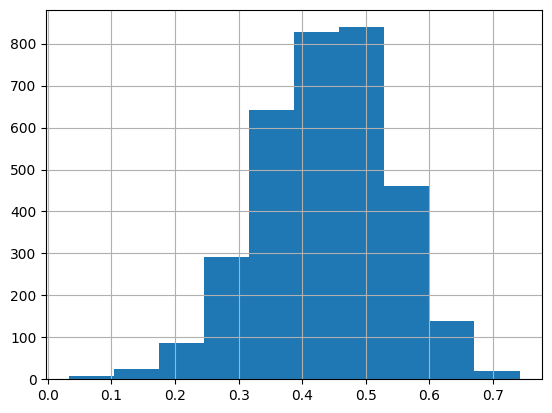

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tmpDf = pd.DataFrame(relevancy_scores)[['true_chunk_id','similarity_scores']]
tmpDf['score_avg'] = tmpDf.similarity_scores.apply(lambda x: float(np.median(x)))
tmpDf.score_avg.hist()

In [17]:
# Assume you have a list of evaluation data
# Each item in evaluation_data is a dictionary with keys:
# - 'question': The user question
# - 'reference_answer': The expected correct answer (could be the chunk content)
evaluation_data = []

# Populate evaluation_data with your existing questions and reference answers
for item in tqdm(questions_data):
    for question in item['questions']:
        # Use the original chunk content as the reference answer
        chunk_id = item['chunk_id']
        content = chunk_content[chunk_id]  # Implement this function to fetch content
        evaluation_data.append({
            'question': question,
            'reference_answer': content
        })


100%|██████████| 668/668 [00:00<00:00, 214237.27it/s]


In [33]:


def evaluate_rag_system(evaluation_data):
    for item in tqdm(evaluation_data):
        if 'rag_answer' in item.keys() :
            pass
        else:
            question = item['question']
            # Generate the RAG answer
            rag_answer = rag_pipeline(question)
            item['rag_answer'] = rag_answer
    return evaluation_data

# Run the evaluation
# evaluation_data = evaluate_rag_system(evaluation_data)


In [18]:
def llm_judge(question, reference_answer, rag_answer, model='gpt-4o-mini'):
    prompt = f"""
You are an expert evaluator. Compare the following two answers to the question provided. 
Assess the RAG-generated answer based on correctness, completeness, and relevance to the question, using the reference answer as the ground truth. 
Provide a score between 1 and 5, where 5 is the best; follow the below scoring guidelines for scoring.
Scoring Guidelines:
- 5: The RAG-generated answer is completely correct, fully addresses the question, and is as comprehensive as the reference answer.
- 4: The answer is correct but may lack minor details compared to the reference.
- 3: The answer is partially correct but misses significant details.
- 2: The answer has some correct elements but contains notable inaccuracies.
- 1: The answer is incorrect or irrelevant to the question.


**Question:**
{question}

**Reference Answer:**
{reference_answer}

**RAG-Generated Answer:**
{rag_answer}

**Evaluation:**
Score:"""

    response = client.chat.completions.create(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        max_tokens=150,
        temperature=0,
        n=1,
        stop=None
    )
    evaluation_text = response.choices[0].message.content.strip()
    # Parse the score and reasoning
    score, reasoning = parse_evaluation(evaluation_text)
    return score, reasoning

def parse_evaluation(evaluation_text):
    # Split the evaluation text to extract score and reasoning
    lines = evaluation_text.split('\n')
    score = None
    reasoning = ''
    for line in lines:
        if line.strip().startswith('Score:'):
            score_line = line.strip()
            score_str = score_line.replace('Score:', '').strip()
            try:
                score = float(score_str)
            except ValueError:
                score = None
        elif line.strip().startswith('Reasoning:'):
            reasoning = line.strip().replace('Reasoning:', '').strip()
        else:
            if reasoning != '':
                reasoning += ' ' + line.strip()
    return score, reasoning


In [19]:
def run_llm_evaluation(evaluation_data):
    for item in tqdm(evaluation_data):
        question = item['question']
        reference_answer = item['reference_answer']
        rag_answer = item['rag_answer']
        try:
            score, reasoning = llm_judge(question, reference_answer, rag_answer)
            item['score'] = score
            item['reasoning'] = reasoning
        except Exception as e:
            print(f"Error evaluating question '{question}': {e}")
            item['score'] = None
            item['reasoning'] = str(e)
    return evaluation_data

# Run LLM evaluation
# evaluation_data = run_llm_evaluation(evaluation_data)


def analyze_results(evaluation_data):
    valid_scores = [item['score'] for item in evaluation_data if item['score'] is not None]
    average_score = sum(valid_scores) / len(valid_scores) if valid_scores else 0
    print(f"Average Score: {average_score:.2f}")

    # Optional: Analyze reasoning
    for item in evaluation_data:
        print(f"Question: {item['question']}")
        print(f"Score: {item['score']}")
        print(f"Reasoning: {item['reasoning']}")
        print('-' * 50)

# Analyze the results
# analyze_results(evaluation_data)


In [36]:
# Step 2: Run RAG pipeline
evaluation_data = evaluate_rag_system(evaluation_data)


100%|██████████| 3340/3340 [11:16<00:00,  4.94it/s] 


In [37]:
output_path = '../data/evaluation_data.json'
with open(output_path, 'w') as json_file:
    json.dump(evaluation_data, json_file, indent=4)

In [38]:

# Step 3: Use LLM as a judge
evaluation_data = run_llm_evaluation(evaluation_data)


100%|██████████| 3340/3340 [2:53:29<00:00,  3.12s/it]    


In [39]:
output_path = '../data/evaluation_data_fin.json'
with open(output_path, 'w') as json_file:
    json.dump(evaluation_data, json_file, indent=4)

In [1]:

# Step 4: Analyze results
analyze_results(evaluation_data)

NameError: name 'analyze_results' is not defined

In [3]:
output_path = '../data/evaluation_data_fin.json'
with open(output_path, 'r') as json_file:
    evaluation_data = json.load(json_file)

print (len(evaluation_data))
evaluation_data[0]

3340


{'question': 'What is the significance of detecting lead-lag relationships in stock returns?',
 'reference_answer': 'DETECTING LEAD-LAGRELATIONSHIPS IN STOCK RETURNS AND PORTFOLIO STRATEGIES∗ Álvaro Cartea†‡Mihai Cucuringu∗§†¶Qi Jin∗‡∥ June 9, 2024 Click here for the most recent version ABSTRACT We propose a method to detect linear and nonlinear lead-lag relationships in stock returns. Our approach uses pairwise Lévy-area and cross-correlation of returns to rank the assets from leaders to followers. We use the rankings to construct a portfolio that longs or shorts the followers based on the previous returns of the leaders, and the stocks are ranked every time the portfolio is rebalanced. The portfolio also takes an offsetting position on the SPY ETF so that the initial value of the portfolio is zero. Our data spans from 1963 to 2022, and we use an average of over 500 stocks to construct portfolios for each trading day. The annualized returns of our lead-lag portfolios are over 20 %, an

score
4.0    1404
5.0     326
1.0      59
2.0      54
3.0      50
Name: count, dtype: int64

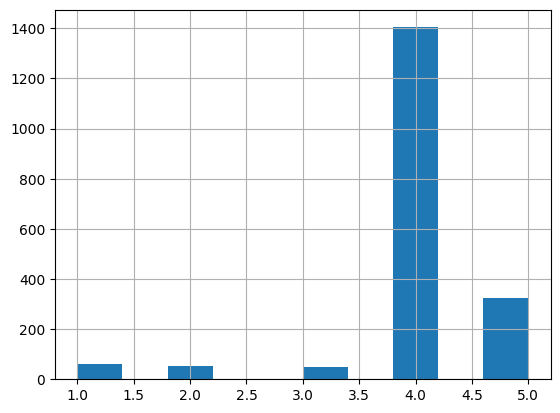

In [8]:
import pandas as pd
pd.DataFrame(evaluation_data)['score'].hist()
pd.DataFrame(evaluation_data)['score'].value_counts()